In [1]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import astropy.units as u
from sunpy.time import TimeRange
import time
import sys

import datetime as dt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec,transforms

%matplotlib inline

In [2]:
sys.path.insert(1, '../../20201013_jupiter/')
from sk import LofarRaw


#rcParams['agg.path.chunksize'] = 10000

In [13]:
mpl.use('pdf')

In [3]:
filename = '../udpoutput/cygA-stokesVectors_0_2020-12-15T20:00:00_19629667968374' #0 is I and 1 is V I assume
frange = [15,30]
sbs = np.arange(76,198)
obs_mode = 3
time_len_mins = 2.
trange = TimeRange(filename.split('_')[-2], time_len_mins*u.min)
xlabel = "Time from {} {}".format(filename.split('_')[-2].split('T')[0], filename.split('_')[-2].split('T')[1])
ylabel = "Frequency (MHz)"
title = filename.split('/')[2]

In [15]:
#off_fname = '../udpoutput/offsource-stokesVectors_0_2020-12-15T20:04:00_19629670898060'
#trange is the same for both beams
#time_len_mins = 176.
#offtrange = TimeRange(off_fname.split('_')[-2], time_len_mins*u.min)
#offxlabel = "Time from {} {}".format(off_fname.split('_')[-2].split('T')[0], off_fname.split('_')[-2].split('T')[1])
#offylabel = "Frequency (MHz)"
#offtitle = off_fname.split('/')[2]

In [4]:
# read in the data (stokes I or V from udpPM)
raw = LofarRaw(fname=filename, sbs=sbs, obs_mode=obs_mode, frange=frange)
raw.data = raw.data[:,:78] ###the rest of the subbands are empty because of the way ilofar/realta records data into the data lanes
#offraw = LofarRaw(fname=off_fname, sbs=sbs, obs_mode=obs_mode, frange=frange)
#offraw.data = offraw.data[:,:78]

Time to read data: 0.000860s



In [5]:
flimits = np.array([0,78])
freqlimits = raw.sb_to_f(flimits+sbs[0], obs_mode)
xlims = list(map(dt.datetime.fromisoformat, [trange.start.value, trange.end.value]))
xlims = mdates.date2num(xlims)

In [6]:
datasplit = 10
normseconds = 42
norm_splits = int(((trange.minutes.value/datasplit)*60)/normseconds)

tchunks = trange.split(datasplit)
#datas = np.array_split(raw.data, datasplit, axis=0)
#offdatas = np.array_split(offraw.data, datasplit, axis=0)

In [7]:
def plot_data(data, trange, flims, xlabel, ylabel, plotname):
    f = plt.figure(figsize=(12,6))
    f.set_facecolor('white')

    spec = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[6,1], height_ratios=[1,4])
    ax0 = f.add_subplot(spec[0])
    ax2 = f.add_subplot(spec[2])
    ax3 = f.add_subplot(spec[3])

    xs = data.T.sum(axis=0)
    ys = data.T.sum(axis=1)

    ax0.plot(xs, lw=0.5)
    ax0.set(xticklabels=[], xlim=[0,None])
    ax0.tick_params(bottom=False)

    rot = transforms.Affine2D().rotate_deg(270)
    ax3.plot(ys[::-1], lw=0.5, transform=rot+plt.gca().transData)
    ax3.set(yticklabels=[])
    ax3.tick_params(left=False)

    xlims = list(map(dt.datetime.fromisoformat, [trange.start.value, trange.end.value]))
    xlims = mdates.date2num(xlims)

    im = ax2.imshow(data.T, aspect='auto', origin='lower',
            vmin=np.nanpercentile(data.T, 5), 
            vmax=np.nanpercentile(data.T, 90),
            extent=[xlims[0], xlims[1], 
                    flims[0].value, flims[1].value])

    ax2.xaxis_date()
    date_format = mdates.DateFormatter('%H:%M:%S')
    ax2.xaxis.set_major_formatter(date_format)

    ax2.set_title("CygA observation - Stokes I")
    ax2.set_ylabel(ylabel, fontsize=14)
    ax2.set_xlabel(xlabel, fontsize=14)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.savefig(plotname, dpi=900)

In [8]:
datas = raw.data

	Data downsampled x1831
	 Data shape: (801, 78)
	Plotting...



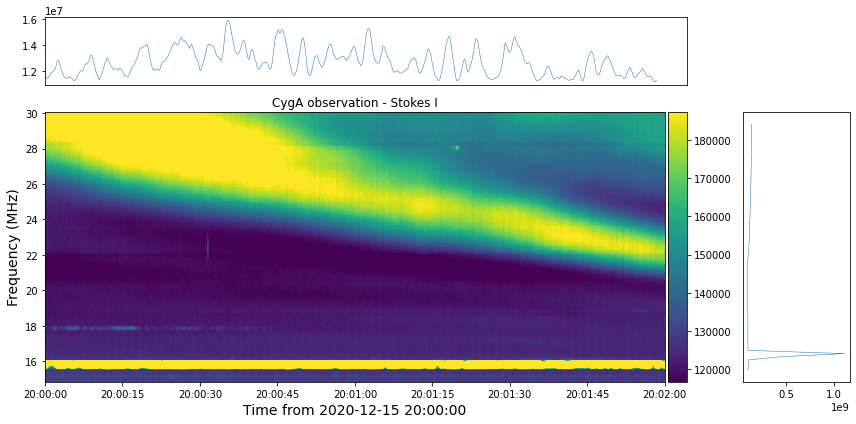

In [59]:
#print("Analysing chunk #{} of data".format(i+1))

#bg = np.true_divide(j, offdatas[i], out=np.zeros_like(j), where=offdatas[i]!=0) #bg removal... (?) I think

#dec = 256
#dec = 3662 # dec = 3662 gives a resolution of 150 ms
#summed = np.cumsum(bg, axis=0)
#dec_data = summed[dec::dec, :] - summed[:-dec:dec, :]

dec = 1831 #resolution of 150ms for this method
pad = np.ceil(float(datas.shape[0])/dec)*dec - datas.shape[0]
pad_arr = np.zeros((int(pad), datas.shape[1]))*np.NaN
bg_padded = np.append(datas, pad_arr).reshape(-1, datas.shape[1])
dec_data = np.nanmean(bg_padded.T.reshape(datas.shape[1], -1, dec), axis=2).T

#print('\tData downsampled x{}'.format(int(dec/2)))
print('\tData downsampled x{}'.format(int(dec)))
print('\t Data shape: {}'.format(dec_data.shape))

print("\tPlotting...\n")
plot_data(dec_data, trange, freqlimits, xlabel, ylabel, 'cygA_calibrator_plots/cyg_A_stokesI')

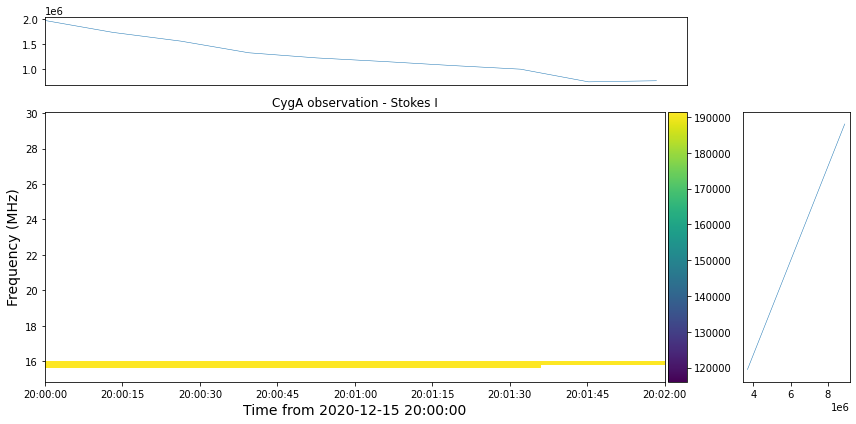

In [69]:
t = np.ma.masked_less(dec_data[20:30], dec_data[20:30].mean()+dec_data[20:30].std())
plot_data(t, trange, freqlimits, xlabel, ylabel, 'cygA_calibrator_plots/cyg_A_stokesI')

In [46]:
dec_data.shape

(801, 78)

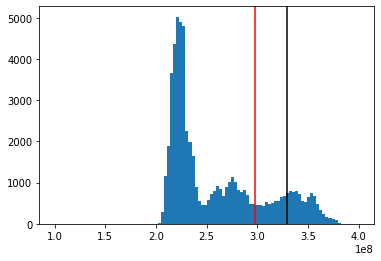

In [51]:
plt.hist(dec_data.flatten(), bins=100, range=(1e8,4e8))
plt.axvline(dec_data.mean(), c='r')
plt.axvline(dec_data.std(), c='k')
#plt.xscale('log')

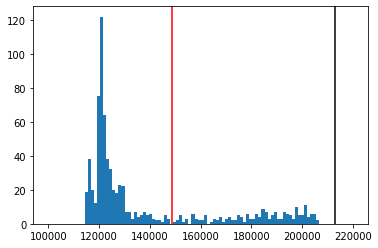

In [65]:
plt.hist(dec_data[30:40].flatten(), bins=100, range=(100000,220000))
plt.axvline(dec_data[30:50].mean(), c='r')
plt.axvline(dec_data[30:50].mean()+dec_data[30:40].std(), c='k')
#plt.xscale('log')

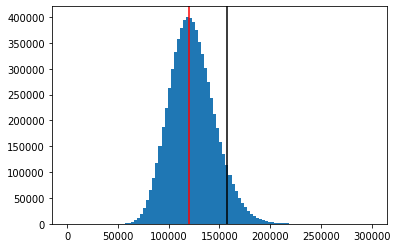

In [67]:
plt.hist(datas[:,10:15].flatten(), bins=100, range=(100,3e5))
plt.axvline(datas[:,20:30].mean(), c='r')
plt.axvline(datas[:,20:30].mean()+ datas[:,10:].std(), c='k')
#plt.xscale('log')

In [20]:
datas.std()

187578.16

(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.0000000e+00, 3.9300000e+02, 9.2440000e+03,
        1.1190000e+05, 7.7977200e+05, 3.2627390e+06, 8.7076870e+06,
        1.5514728e+07, 1.9560956e+07, 1.8769839e+07, 1.5084968e+07,
        1.1137184e+07, 7.8546630e+06, 5.1799490e+06, 3.0663180e+06,
        1.5879850e+06, 7.2741200e+05, 3.1466300e+05, 1.5242400e+05,
        9.9333000e+04, 8.4638000e+04, 8.1635000e+04, 8.0567000e+04,
        7.9197000e+04, 7.6984000e+04, 7.4923000e+04, 7.1274000e+04,
        6.7922000e+04, 6.4490000e+04, 6.0981000e+04, 5.8673000e+04,
        5.6723000e+04, 5.4767000e+04, 5.2898000e+04, 5.0933000e+04,
        4.9784000e+04, 4.8523000e+04, 4.6666000e+04, 4.5790000e+04,
        4.4668000e+04, 4.3138000e+04]),
 array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
  

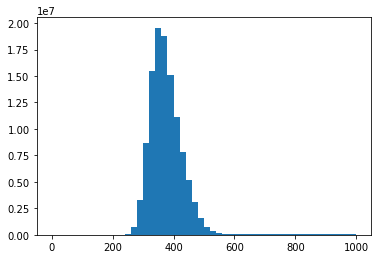

In [28]:
plt.hist(np.sqrt(datas.flatten()), bins=50, range=(0,1000))
#plt.axvline(datas.mean(), c='r')
#plt.axvline(datas.std(), c='k')

In [29]:
sq_dat = np.sqrt(datas)

In [31]:
sq_dat.min()

191.21454

In [32]:
datas.min()

36563.0